In [116]:
from datetime import datetime
import json

import matplotlib.pyplot as plt
import numpy as np

from search_clustering.pipeline import *
from search_clustering.client import *
from search_clustering.preprocessing import *
from search_clustering.embedding import *
from search_clustering.reduction import *
from search_clustering.clustering.knn import *
from search_clustering.clustering.temporal import *
from search_clustering.labeling import *

In [341]:
query = "heidelberg"
samples = 500
use_cached_data = True

if not use_cached_data:
    es = ElasticClient()

    for index in es.client.indices.get_alias():
        print(index)

    results = es.search(index="faz", field="body", query=query, size=10_000)

    with open(f"datasets/{query.replace(' ', '_')}.json", "w") as json_file:
        json.dump(results, json_file)


with open(f"datasets/{query.replace(' ', '_')}.json", "r") as json_file:
    results = json.load(json_file)
    results = [
        res
        for res in results
        if res["_source"]["publication_date"] is not None
        and "\n" in res["_source"]["body"]
    ][:samples]


print(f"{len(results)} results")

498 results


# Paragraph-wise Feature Extraction Performance

In [3]:
n = 100
docs = ParagraphSplitter().transform(results[:n])

def measure_time(extractor: Preprocessing):
    start = datetime.now()
    extractor.transform(docs)
    stop = datetime.now()
    delta = stop - start
    return delta.total_seconds()

# LDA
# extractor = ParagraphTopicModeling(language="de")
# print("LDA:", measure_time(extractor))
print("LDA: 1.911818 s")

# SingleRank
# extractor = ParagraphGraphKeyphraseExtractor(language="de")
# print("SingleRank:", measure_time(extractor)
print("SingleRank: 530.79671 s")

# KeyBERT
# extractor = ParagraphLLMKeyphraseExtractor(language="de")
# print("KeyBERT:", measure_time(extractor))
print("KeyBERT: 18.769 s")

LDA: 1.911818 s
SingleRank: 530.79671 s
KeyBERT: 18.769 s


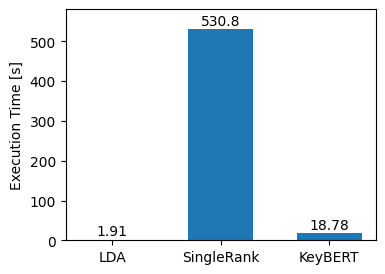

In [172]:
plt.figure(figsize=(4, 3))

x = np.arange(3) / 2
heights = [1.91, 530.80, 18.78]
labels = ["LDA", "SingleRank", "KeyBERT"]
offset = 10

plt.bar(x, heights, 0.3)
for i in range(3):
    plt.text(x[i], heights[i] + offset, heights[i] , ha="center")

plt.xticks(x, ["LDA", "SingleRank", "KeyBERT"])
plt.ylabel("Execution Time [s]")
plt.ylim(0, max(heights) + 5 * offset)
plt.show()

# Clustering Plots

[1/6] Preprocessing


C:\Users\Christopher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


[2/6] Embedding
[3/6] Reducing Dimensionality
[4/6] Clustering
[5/6] Labeling
[6/6] Visualizing


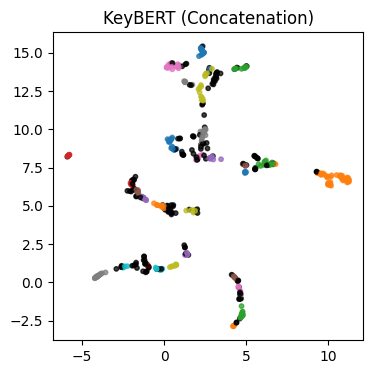

'\n# KPE 2\npipe = KNNPipeline(\n    preprocessing=[\n        ParagraphSplitter(),\n        ParagraphLLMKeyphraseExtractor("de"),\n    ],\n    embedding=PooledEmbeddings("keyphrases"),\n    reduction=Umap(),\n    clustering=clustering,\n    labeling=FrequentPhrases(language="de", n_phrases=2),\n)\n\ndocs, clusters, labels, score = pipe.fit_transform(results, title="KeyBERT (Weighted Pooling)", legend=False)\n'

In [343]:
clustering = HDBSCAN()

"""
# LDA 1
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphTopicModeling("de"),
        ListJoiner("topics"),
    ],
    embedding=SentenceMiniLM("joined"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de"),
)
docs, clusters, labels, score = pipe.fit_transform(results, title="LDA (Concatenation)", legend=False)

# LDA 2
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphTopicModeling("de"),
    ],
    embedding=PooledEmbeddings("topics"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de"),
)
pipe.fit_transform(results, title="LDA (Weighted Pooling)", legend=False)
"""
# KPE 1
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphLLMKeyphraseExtractor("de"),
        ListJoiner("keyphrases"),
    ],
    embedding=SentenceMiniLM("joined"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de"),
)
docs, clusters, labels, score = pipe.fit_transform(results, title="KeyBERT (Concatenation)", legend=False)
"""
# KPE 2
pipe = KNNPipeline(
    preprocessing=[
        ParagraphSplitter(),
        ParagraphLLMKeyphraseExtractor("de"),
    ],
    embedding=PooledEmbeddings("keyphrases"),
    reduction=Umap(),
    clustering=clustering,
    labeling=FrequentPhrases(language="de", n_phrases=2),
)

docs, clusters, labels, score = pipe.fit_transform(results, title="KeyBERT (Weighted Pooling)", legend=False)
"""


# Hierarchical Clustering Plots

[6/6] Visualizing


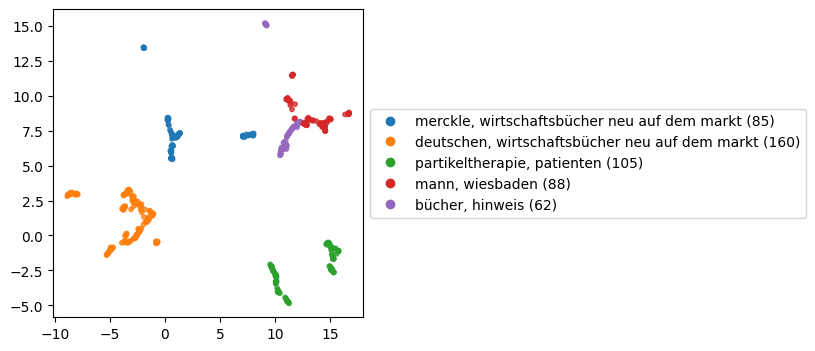

[6/6] Visualizing


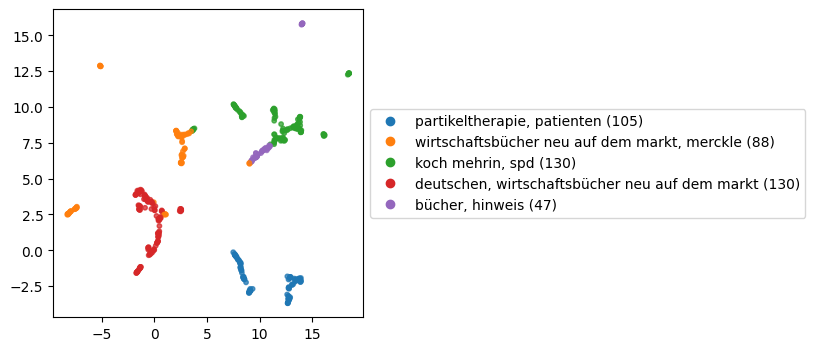

[6/6] Visualizing


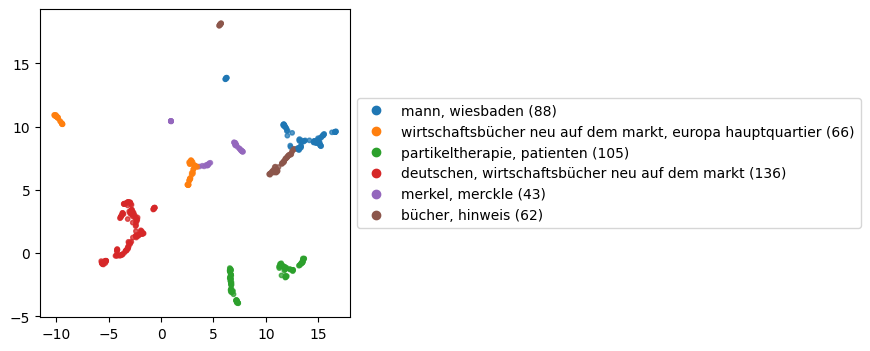

[6/6] Visualizing


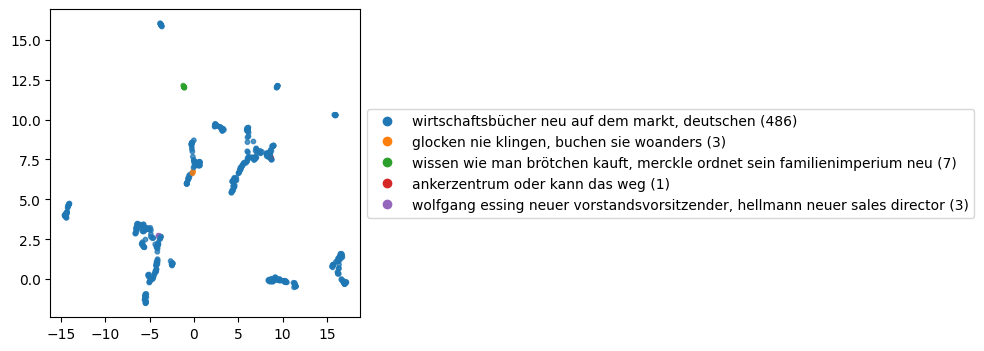

In [29]:
linkages = ["ward", "complete", "average", "single"]

for linkage in linkages:
    pipe = KNNPipeline(
        preprocessing=[
            ParagraphSplitter(),
            ParagraphLLMKeyphraseExtractor("de"),
        ],
        embedding=PooledEmbeddings("keyphrases"),
        reduction=Umap(),
        clustering=HierarchicalClustering(linkage=linkage),
        labeling=FrequentPhrases(language="de", n_phrases=2),
    )
    docs, clusters, labels, score = pipe.fit_transform(results, verbose=False, query="heidelberg")

# Temporal Scatterplot

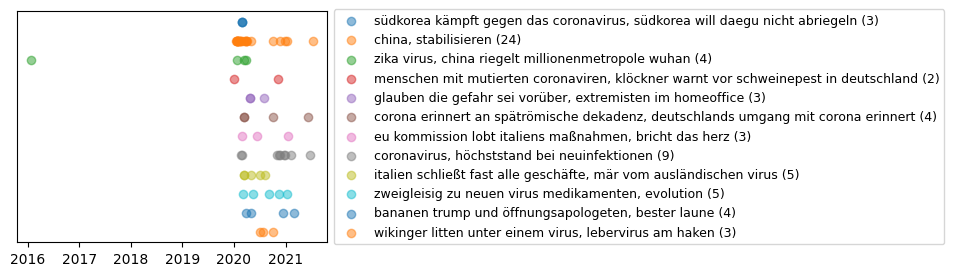

In [280]:
def scatter_temporal(docs, clusters):
    plt.figure(figsize=(4, 3))
    idx = sorted(set(clusters))
    idx = [idx[1]] + idx[3:13] + [idx[14]]  # 12 clusters for nice layout

    for j in range(len(idx)):  
        indices = np.where(clusters == idx[j])[0]
        timestamps = [docs[i]["_source"]["publication_date"] for i in indices]
        timestamps = [datetime.strptime(stamp, "%Y-%m-%d %H:%M:%S") for stamp in timestamps]
        plt.scatter(
            timestamps,
            [len(labels) - j - 1 for _ in range(len(timestamps))],
            label=labels[idx[j]],
            alpha=0.5,
        )
    plt.yticks([])
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
    plt.show()

scatter_temporal(results, clusters)

other = np.take(results, np.where(clusters == 0)[0])
for doc in other:
    break
    print(doc["_source"]["title"])

# BM 25 Robustness

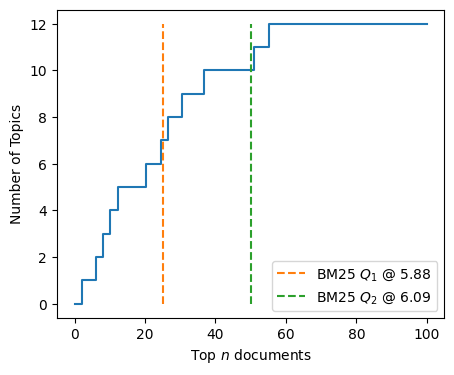

25.0

In [275]:
bm25_docs = [doc["_score"] for doc in docs]
bm25_clusters = []
for c in sorted(set(clusters)):
    cluster = np.take(docs, np.where(clusters == c)[0])
    bm25_clusters.append(max([doc["_score"] for doc in cluster]))

qs = np.linspace(0, 1)
counts = []

for q in qs:
    indices = (np.array(bm25_clusters) < np.quantile(bm25_docs, q)).nonzero()[0]
    counts.append(len(indices))

plt.figure(figsize=(5, 4))
plt.step(qs[::-1] * len(docs), max(counts) - np.array(counts))
plt.vlines(len(docs) / 4, 0, max(counts), color="C1", linestyle="dashed", label=f"BM25 $Q_1$ @ {np.quantile(bm25_docs, 0.25):.2f}")
plt.vlines(len(docs) / 2, 0, max(counts), color="C2", linestyle="dashed", label=f"BM25 $Q_2$ @ {np.median(bm25_docs):.2f}")
plt.xlabel("Top $n$ documents")
plt.ylabel("Number of Topics")
plt.legend(loc="lower right")
plt.show()

0.25 * len(docs)

# HDBSCAN n_clusters

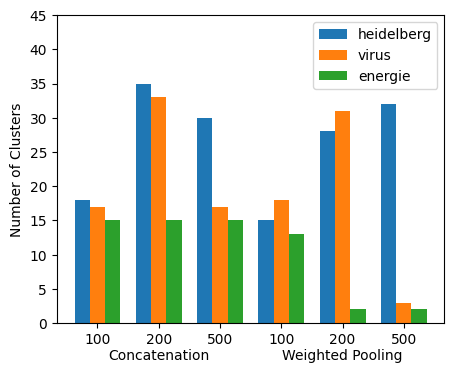

In [319]:
queries = ["heidelberg", "virus", "energie"]
width = 0.25
x = np.arange(6)
colors = ["C0", "C1", "C2"]
# energie: only 154

heights_concat_100 = [18, 17, 15]
heights_concat_200 = [35, 33, 15]
heights_concat_500 = [30, 17, 15]
heights_weighted_100 = [15, 18, 13]
heights_weighted_200 = [28, 31, 2]
heights_weighted_500 = [32, 3, 2]

heights_heidelberg = [18, 35, 30, 15, 28, 32]
heights_virus = [17, 33, 17, 18, 31, 3]
heights_energie = [15, 15, 15, 13, 2, 2]

plt.figure(figsize=(5,4))

plt.bar(x - width, heights_heidelberg, width, color="C0", label="heidelberg")
plt.bar(x, heights_virus, width, color="C1", label="virus")
plt.bar(x + width, heights_energie, width, color="C2", label="energie")

plt.xticks(x, [100, "200\nConcatenation", 500, 100, "200\nWeighted Pooling", 500])
plt.ylim(0, 45)
plt.ylabel("Number of Clusters")
plt.legend(loc="upper right")
plt.show()

# Concatenation vs Weighted Pooling Performance

In [340]:
paragraphs = ParagraphSplitter().transform(results)
paragraphs = ParagraphLLMKeyphraseExtractor("de").transform(paragraphs)

start = datetime.now()
paragraphs = ListJoiner("keyphrases").transform(paragraphs)
SentenceMiniLM("joined").transform(paragraphs)
stop = datetime.now()
delta_concat = stop - start

start = datetime.now()
PooledEmbeddings("keyphrases").transform(paragraphs)
stop = datetime.now()
delta_pooled = stop - start

print(delta_pooled / delta_concat)

2023-04-13 06:34:26,008 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,621 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,622 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,623 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,624 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,625 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,626 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,627 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,628 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2023-04-13 06:34:29,629 Warning: An empty Sentence was 

# Temporal Clustering

In [344]:
pipe = TemporalPipeline(DummyPreprocessor(), TemporalClustering(), TemporalLabeling())
docs, clusters, labels = pipe.fit_transform(results)

[1/4] Preprocessing
[2/4] Clustering


TypeError: cannot astype a datetimelike from [datetime64[ns]] to [int32]